In [ ]:
!pip install keras-core


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
pip install tensorflow


In [ ]:
!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.1 requires keras<2.13,>=2.12.0, but you have keras 3.0.0 which is incompatible.


In [ ]:
! pip install scikeras[tensorflow]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 38.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1

In [ ]:
#Final code for CNN vs GBM vs RF vs Super learner
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load your data
file_path = "G:\\My Drive\\ML project\\predictive_maintenance.csv"
data = pd.read_csv(file_path)

# Encode 'Failure Type' column
label_encoder = LabelEncoder()
data['Failure Type'] = label_encoder.fit_transform(data['Failure Type'])

# One-hot encode 'Product ID' and 'Type' columns
columns_to_encode = ['Product ID', 'Type']
for column in columns_to_encode:
    one_hot_encoding = pd.get_dummies(data[column], prefix=column, drop_first=True)
    data = data.drop(column, axis=1)
    data = pd.concat([data, one_hot_encoding], axis=1)

# Assume 'features' contains your feature columns and 'target' contains your target variable
features = data.drop(['Target'], axis=1)
target = data['Target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define base learners
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gbm = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Define a CNN as one of the base learners with RBM
cnn_rbm = Pipeline(
    steps=[
        ("rbm", BernoulliRBM(n_components=256, learning_rate=0.01, n_iter=20, verbose=0)),
        ("scaler", StandardScaler()),
        ("classifier", SVC(C=1000, gamma=0.1, probability=True)),  # Enable probability estimates
    ]
)

# Create a k-fold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store base learner predictions
rf_predictions = []
gbm_predictions = []
cnn_rbm_predictions = []

# Iterate through each fold for training and predictions
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train Random Forest on the fold
    rf.fit(X_train_fold, y_train_fold)
    rf_fold_pred = rf.predict(X_val_fold)
    rf_predictions.extend(rf_fold_pred)

    # Train Gradient Boosting on the fold
    gbm.fit(X_train_fold, y_train_fold)
    gbm_fold_pred = gbm.predict(X_val_fold)
    gbm_predictions.extend(gbm_fold_pred)

    # Train CNN with RBM on the fold
    cnn_rbm.fit(X_train_fold, y_train_fold)
    cnn_rbm_fold_pred = cnn_rbm.predict(X_val_fold)
    cnn_rbm_predictions.extend(cnn_rbm_fold_pred)

# Combine base learner predictions into a DataFrame
base_learner_predictions = pd.DataFrame({'RF': rf_predictions, 'GBM': gbm_predictions, 'CNN_RBM': cnn_rbm_predictions})

# Define and train the super learner on the base learner predictions
super_learner = VotingClassifier(estimators=[('rf', rf), ('gbm', gbm), ('cnn_rbm', cnn_rbm)], voting='soft')
super_learner.fit(base_learner_predictions, y_train)

# Make predictions on the test set using base learners
rf_test_pred = rf.predict(X_test)
gbm_test_pred = gbm.predict(X_test)
cnn_rbm_test_pred = cnn_rbm.predict(X_test)

# Combine test set predictions into a DataFrame
test_set_predictions = pd.DataFrame({'RF': rf_test_pred, 'GBM': gbm_test_pred, 'CNN_RBM': cnn_rbm_test_pred})

# Make predictions on the test set using the super learner
super_learner_test_pred = super_learner.predict(test_set_predictions)

# Evaluate the performance of base learners and the super learner
rf_precision = precision_score(y_test, rf_test_pred)
rf_recall = recall_score(y_test, rf_test_pred)
rf_f1 = f1_score(y_test, rf_test_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))

gbm_precision = precision_score(y_test, gbm_test_pred)
gbm_recall = recall_score(y_test, gbm_test_pred)
gbm_f1 = f1_score(y_test, gbm_test_pred)
gbm_rmse = np.sqrt(mean_squared_error(y_test, gbm_test_pred))

cnn_rbm_precision = precision_score(y_test, cnn_rbm_test_pred)
cnn_rbm_recall = recall_score(y_test, cnn_rbm_test_pred)
cnn_rbm_f1 = f1_score(y_test, cnn_rbm_test_pred)
cnn_rbm_rmse = np.sqrt(mean_squared_error(y_test, cnn_rbm_test_pred))

super_learner_precision = precision_score(y_test, super_learner_test_pred)
super_learner_recall = recall_score(y_test, super_learner_test_pred)
super_learner_f1 = f1_score(y_test, super_learner_test_pred)
super_learner_rmse = np.sqrt(mean_squared_error(y_test, super_learner_test_pred))
rf_accuracy = accuracy_score(y_test, rf_test_pred)
gbm_accuracy = accuracy_score(y_test, gbm_test_pred)
cnn_rbm_accuracy = accuracy_score(y_test, cnn_rbm_test_pred)
super_learner_accuracy = accuracy_score(y_test, super_learner_test_pred)

print("Random Forest Metrics:")
print(f'Precision: {rf_precision:.4f}')
print(f'Recall: {rf_recall:.4f}')
print(f'F-measure: {rf_f1:.4f}')
print(f'RMSE: {rf_rmse:.4f}')
print(f'Accuracy: {rf_accuracy:.4f}')

print("\nGradient Boosting Metrics:")
print(f'Precision: {gbm_precision:.4f}')
print(f'Recall: {gbm_recall:.4f}')
print(f'F-measure: {gbm_f1:.4f}')
print(f'RMSE: {gbm_rmse:.4f}')
print(f'Accuracy: {gbm_accuracy:.4f}')

print("\nCNN with RBM Metrics:")
print(f'Precision: {cnn_rbm_precision:.4f}')
print(f'Recall: {cnn_rbm_recall:.4f}')
print(f'F-measure: {cnn_rbm_f1:.4f}')
print(f'RMSE: {cnn_rbm_rmse:.4f}')
print(f'Accuracy: {cnn_rbm_accuracy:.4f}')

print("\nSuper Learner Metrics:")
print(f'Precision: {super_learner_precision:.4f}')
print(f'Recall: {super_learner_recall:.4f}')
print(f'F-measure: {super_learner_f1:.4f}')
print(f'RMSE: {super_learner_rmse:.4f}')
print(f'Accuracy: {super_learner_accuracy:.4f}')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the performance of base learners and the super learner
rf_precision = precision_score(y_test, rf_test_pred)
rf_recall = recall_score(y_test, rf_test_pred)
rf_f1 = f1_score(y_test, rf_test_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))

gbm_precision = precision_score(y_test, gbm_test_pred)
gbm_recall = recall_score(y_test, gbm_test_pred)
gbm_f1 = f1_score(y_test, gbm_test_pred)
gbm_rmse = np.sqrt(mean_squared_error(y_test, gbm_test_pred))

cnn_rbm_precision = precision_score(y_test, cnn_rbm_test_pred)
cnn_rbm_recall = recall_score(y_test, cnn_rbm_test_pred)
cnn_rbm_f1 = f1_score(y_test, cnn_rbm_test_pred)
cnn_rbm_rmse = np.sqrt(mean_squared_error(y_test, cnn_rbm_test_pred))

super_learner_precision = precision_score(y_test, super_learner_test_pred)
super_learner_recall = recall_score(y_test, super_learner_test_pred)
super_learner_f1 = f1_score(y_test, super_learner_test_pred)
super_learner_rmse = np.sqrt(mean_squared_error(y_test, super_learner_test_pred))

# Plot accuracy comparison
models = ['Random Forest', 'Gradient Boosting', 'CNN with RBM', 'Super Learner']
accuracies = [rf_accuracy, gbm_accuracy, cnn_rbm_accuracy, super_learner_accuracy]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

# Plot confusion matrices
def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix('Random Forest', y_test, rf_test_pred)
plot_confusion_matrix('Gradient Boosting', y_test, gbm_test_pred)
plot_confusion_matrix('CNN with RBM', y_test, cnn_rbm_test_pred)
plot_confusion_matrix('Super Learner', y_test, super_learner_test_pred)

# Compare other metrics
metrics_df = pd.DataFrame({
    'Model': models,
    'Precision': [rf_precision, gbm_precision, cnn_rbm_precision, super_learner_precision],
    'Recall': [rf_recall, gbm_recall, cnn_rbm_recall, super_learner_recall],
    'F-measure': [rf_f1, gbm_f1, cnn_rbm_f1, super_learner_f1],
    'RMSE': [rf_rmse, gbm_rmse, cnn_rbm_rmse, super_learner_rmse],
})

# Plot other metrics comparison
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.barplot(x='Model', y='value', hue='variable', data=pd.melt(metrics_df, id_vars='Model'), palette='muted')
plt.title('Other Metrics Comparison')
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Load the dataset
file_path = "/content/predictive_maintenance.csv"
data = pd.read_csv(file_path)

# One-hot encoding for categorical columns
data = pd.get_dummies(data, columns=['Product ID', 'Type', 'Failure Type'], drop_first=True)

# Separate features and targets
features = data.drop(['UDI', 'Target'], axis=1)
target_failure = data['Target']

# Standardize numerical features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Reshape data for LSTM input
features_reshaped = features_standardized.reshape((features_standardized.shape[0], 1, features_standardized.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_reshaped, target_failure, test_size=0.2, random_state=42)

# Define the generator for LSTM-GAN
def build_generator(latent_dim, feature_dim):
    model = Sequential()
    model.add(Dense(50, input_dim=latent_dim, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(feature_dim, activation='linear'))
    return model

# Define the discriminator for LSTM-GAN
def build_discriminator(sequence_length, feature_dim, lstm_units):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(sequence_length, feature_dim), return_sequences=True))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(1, activation='sigmoid'))
    return model

# Define the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Wrap the Keras model for scikit-learn
def create_model(sequence_length=1, batch_size=32, optimizer='adam',
                 lstm_units=100, dense_units=100, gan_loss='binary_crossentropy'):
    # Build the discriminator and generator
    discriminator = build_discriminator(X_train.shape[1], X_train.shape[2], lstm_units)
    generator = build_generator(X_train.shape[2], dense_units)

    # Build the GAN model
    gan = build_gan(generator, discriminator)

    # Compile the GAN model
    gan.compile(loss=gan_loss, optimizer=optimizer)

    return gan

# Create a KerasClassifier with sequence_length parameter
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, sequence_length=1, verbose=0)

# Define the parameter grid
param_dist = {
    'sequence_length': [1, 2],
    'batch_size': [16, 32, 64],
    'optimizer': ['adam', 'rmsprop'],
    'dense_units': [50, 100],
}

# Run randomized search
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    error_score='raise',
)

# Fit the random search model
random_search_results = random_search.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
)

# Print the best hyperparameters
print("Best: %f using %s" % (random_search_results.best_score_, random_search_results.best_params_))
print(f"RMSE: {rmse:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


In [ ]:
!pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.3:
      Successfully uninstalled tensorboard-2.12.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.12.1
    Uninstalling tensorflow-2.12.1:
      Successfully

In [ ]:
print(X_train.shape)
print(y_train.shape)


(8000, 1, 10011)
(8000,)


In [ ]:
print("Original shape of X_test:", X_test.shape)
print("Original shape of y_test:", y_test_binary.shape)

Original shape of X_test: (2000, 10011)
Original shape of y_test: (2000,)


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np

# Load the dataset
file_path ="/content/predictive_maintenance.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset for inspection
print(df.head())

# One-hot encode categorical columns ('Product ID' and 'Type')
df_encoded = pd.get_dummies(df, columns=['Product ID', 'Type'])

# Drop unnecessary columns
df_encoded = df_encoded.drop(columns=['UDI', 'Target', 'Failure Type'])

# Normalize numerical features
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_encoded)

# Display the first few rows of the preprocessed dataset
print(df_normalized[:5])

# Define sequences for LSTM
sequence_length = 10  # Adjust as needed
X = []
y = []
for i in range(len(df_normalized) - sequence_length):
    X.append(df_normalized[i:i + sequence_length])
    y.append(df_normalized[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Print the shape of the sequences
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  
[[0.30434783 0.35802469 0.22293364 ... 0.         0.         1.        ]
 [0.31521739 0.37037

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Reshape

# Load the synthetic dataset
# Assume df is your DataFrame containing the synthetic data

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=['Product ID', 'Type'])

# Drop UDI, Target, and Failure Type columns
df_encoded = df_encoded.drop(columns=['UDI', 'Target', 'Failure Type'])

# Normalize numerical features
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_encoded)

# Define sequences for LSTM
sequence_length = 10  # Adjust as needed
X = []
y = []
for i in range(len(df_normalized) - sequence_length):
    X.append(df_normalized[i:i + sequence_length])
    y.append(df_normalized[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Define batch size
batch_size = 50  # Adjust as needed

# Build the Generator model
generator = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, df_normalized.shape[1])),
    BatchNormalization(),
    Dense(df_normalized.shape[1] * sequence_length, activation='sigmoid'),
    Reshape((sequence_length, df_normalized.shape[1]))
])



# Build the Discriminator model
discriminator = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, df_normalized.shape[1])),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the GAN model
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(sequence_length, df_normalized.shape[1]))
x = generator(gan_input)
gan_output = discriminator(x)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Training the GAN
epochs = 301  # Adjust as needed

for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, X.shape[0], batch_size)
    real_seqs = X[idx]
    real_labels = np.ones((batch_size, 1))

    gen_seqs = generator.predict(np.random.randn(batch_size, sequence_length, df_normalized.shape[1]))
    gen_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_seqs, real_labels)
    d_loss_fake = discriminator.train_on_batch(gen_seqs, gen_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.randn(batch_size, sequence_length, df_normalized.shape[1])
    valid_labels = np.ones((batch_size, 1))

    g_loss = gan.train_on_batch(noise, valid_labels)

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

# Inverse transform to obtain original scale
synthetic_sequences_original_scale = scaler.inverse_transform(synthetic_sequences.reshape(-1, df_normalized.shape[1]))

# Visualize or further evaluate the synthetic sequences as needed

# Generate synthetic sequences for evaluation
num_samples = len(y)  # Use the same number of samples as in the original data
noise_eval = np.random.randn(num_samples, sequence_length, df_normalized.shape[1])
synthetic_sequences = generator.predict(noise_eval)

# Evaluate synthetic sequences
mae = mean_absolute_error(y, synthetic_sequences_original_scale)
rmse = np.sqrt(mean_squared_error(y, synthetic_sequences_original_scale))

# Calculate correlation coefficient for each feature
correlations = [pearsonr(y[:, i], synthetic_sequences_original_scale[:, i])[0] for i in range(y.shape[1])]


print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Correlation Coefficients: {correlations}")

2/2 [==============================] - 1s 64ms/step
Epoch 0, D Loss: 0.6984951496124268, G Loss: 0.0028682691045105457
2/2 [==============================] - 0s 37ms/step
Epoch 100, D Loss: 0.6933651566505432, G Loss: 0.3261381983757019
2/2 [==============================] - 0s 41ms/step
Epoch 200, D Loss: 0.6933125853538513, G Loss: 0.6478603482246399
2/2 [==============================] - 0s 37ms/step
Epoch 300, D Loss: 0.6967847347259521, G Loss: 0.6909489631652832


NameError: ignored

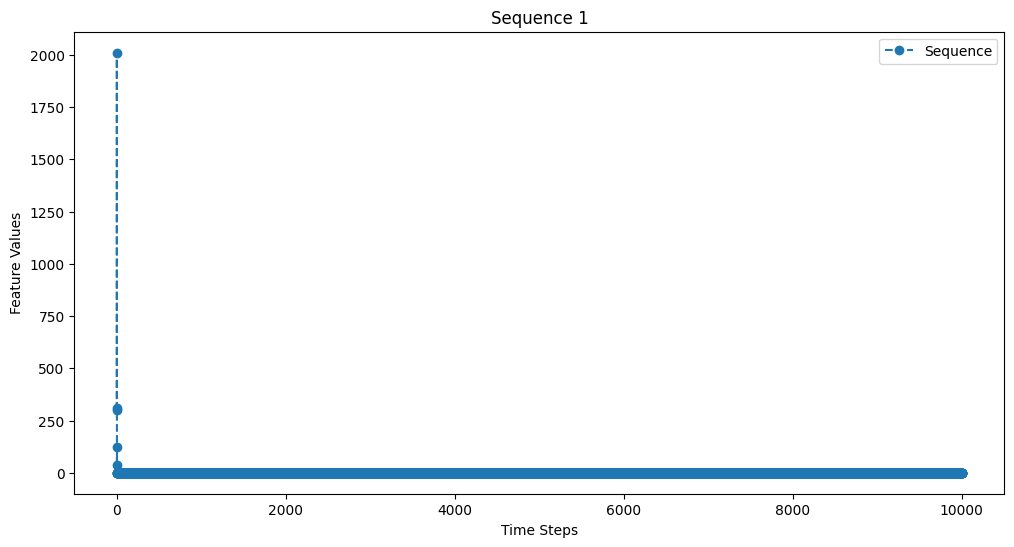

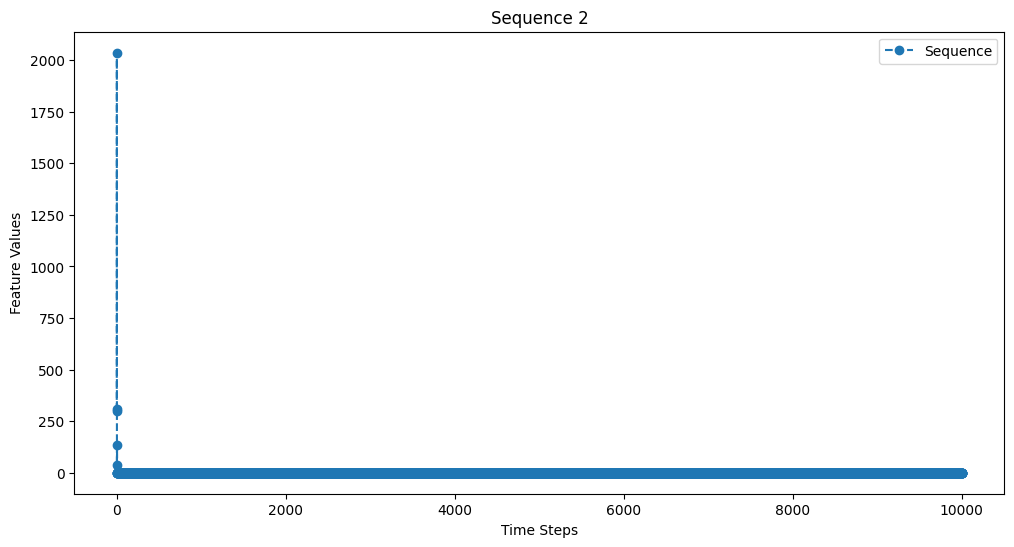

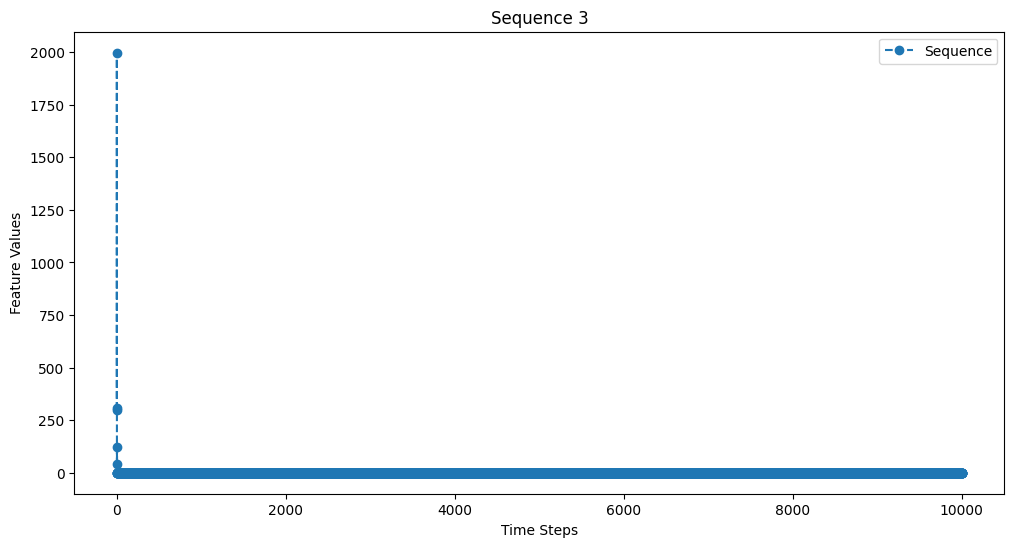

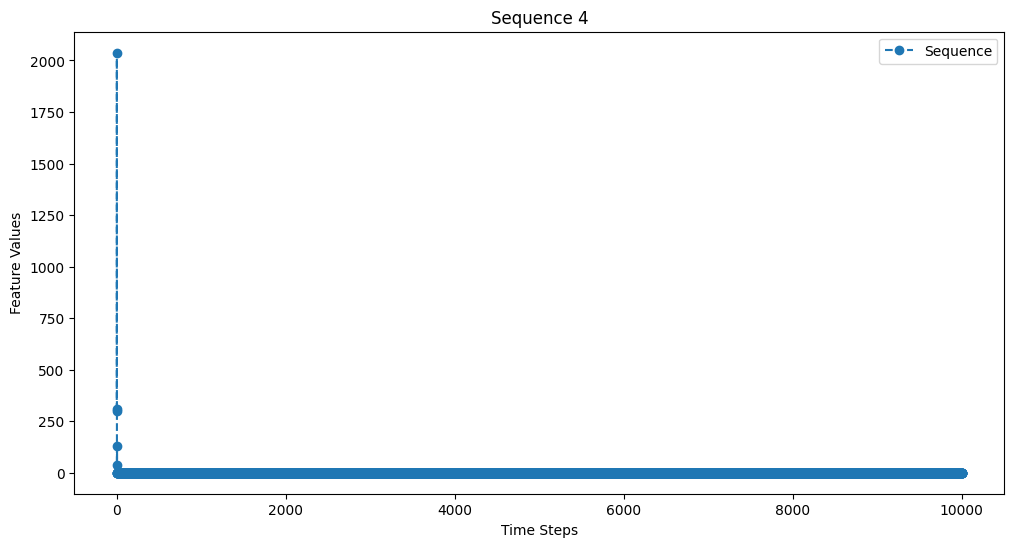

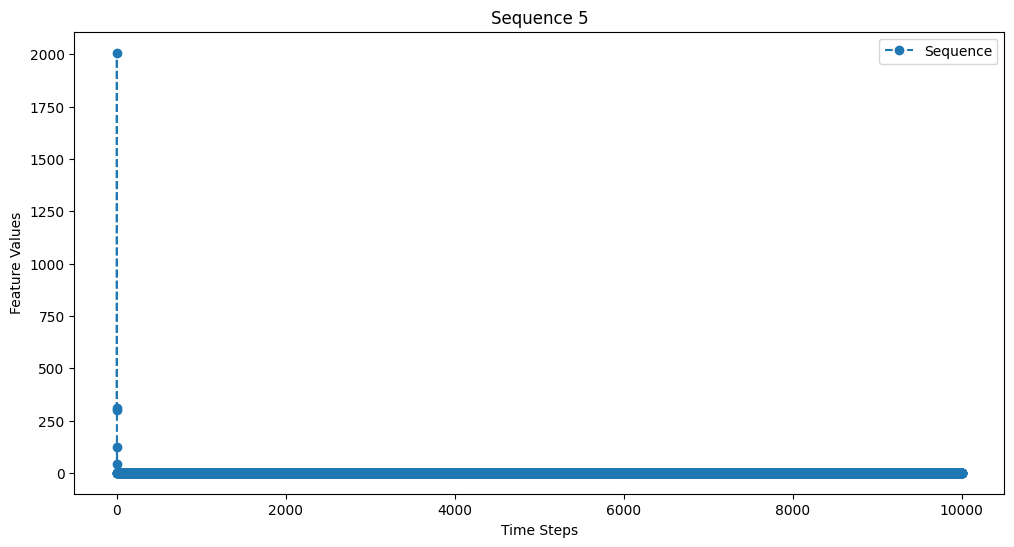

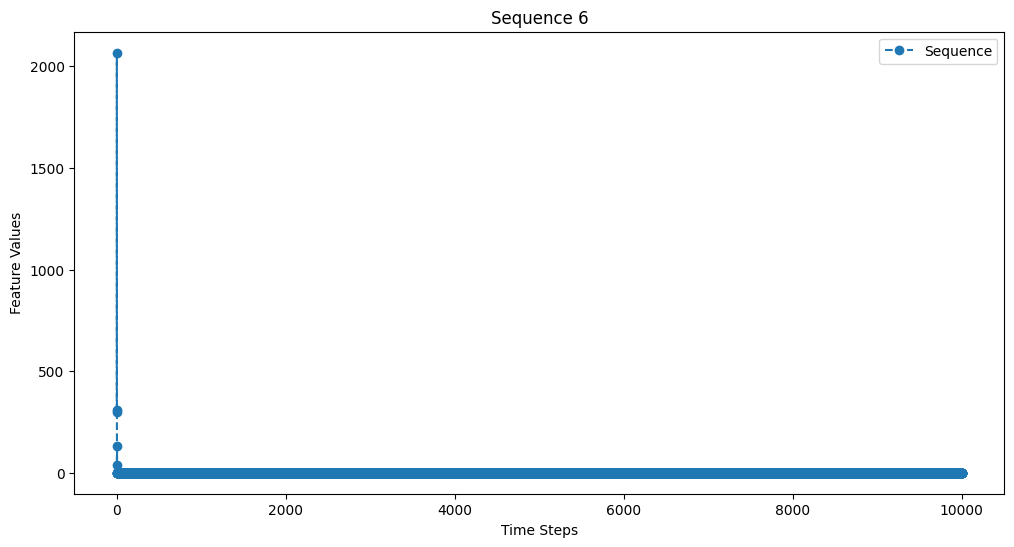

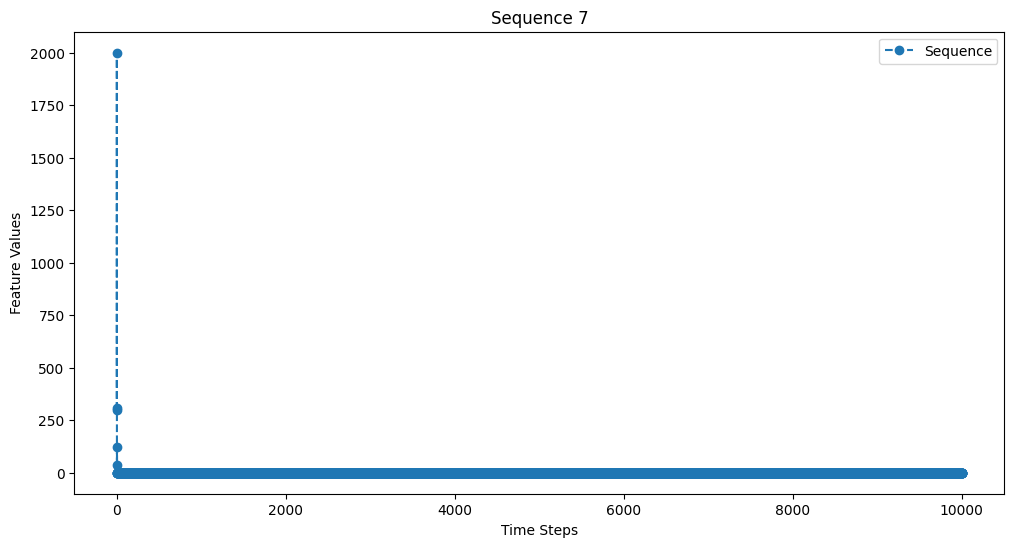

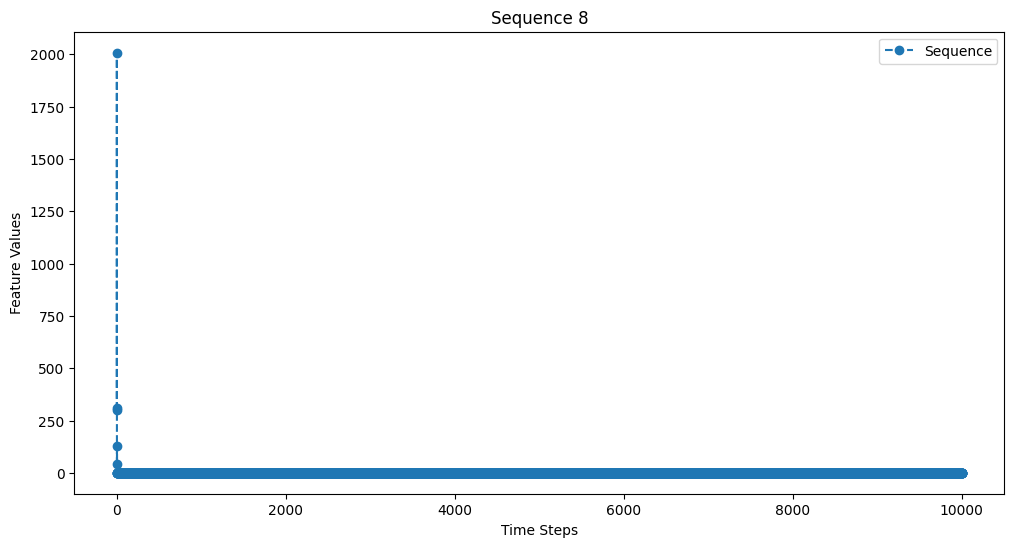

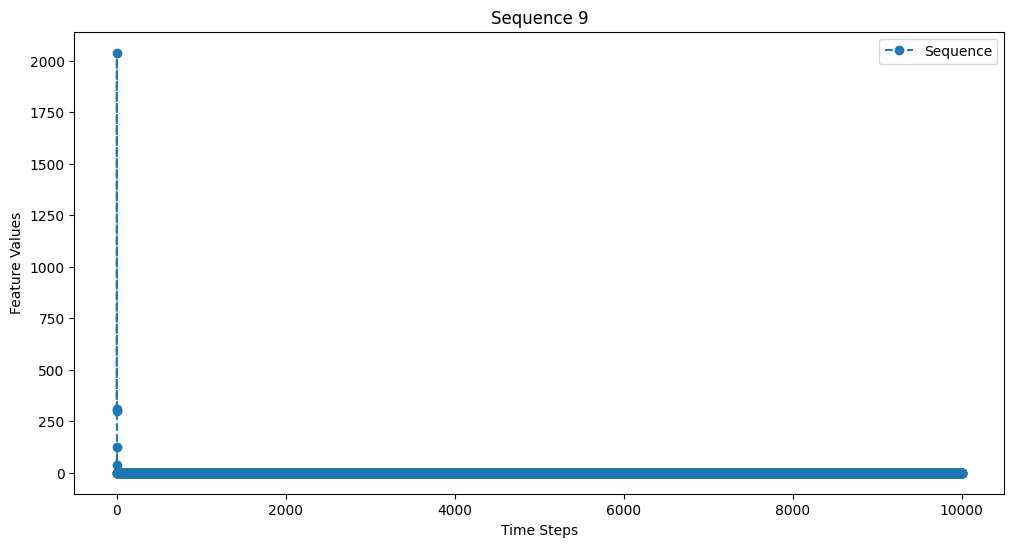

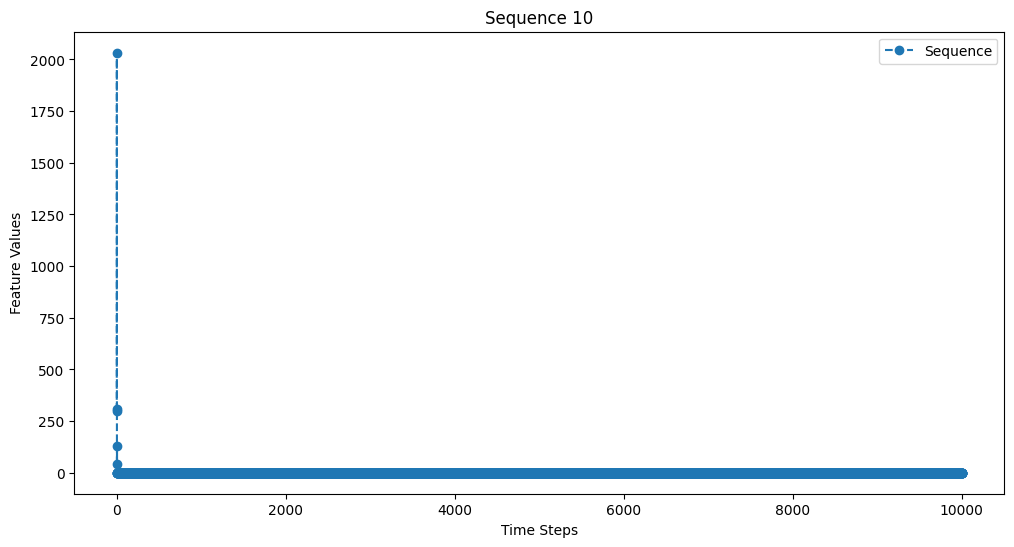

ValueError: ignored

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

# Visualize sequences
for i in range(num_samples):
    plt.figure(figsize=(12, 6))
    plt.plot(synthetic_sequences_original_scale[i, :], label='Sequence', linestyle='--', marker='o')
    plt.xlabel('Time Steps')
    plt.ylabel('Feature Values')
    plt.title(f'Sequence {i + 1}')
    plt.legend()
    plt.show()



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Reshape
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

# Load the synthetic dataset
# Assume df is your DataFrame containing the synthetic data

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=['Product ID', 'Type'])

# Drop UDI, Target, and Failure Type columns
df_encoded = df_encoded.drop(columns=['UDI', 'Target', 'Failure Type'])

# Normalize numerical features
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_encoded)

# Define sequences for LSTM
# Define sequences for LSTM
sequence_length = 10  # Adjust as needed
X = []
y = []
for i in range(len(df_normalized) - sequence_length):
    X.append(df_normalized[i:i + sequence_length])
    y.append(df_normalized[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Define batch size
batch_size = 10  # Adjust as needed

# Build the Generator model
generator = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, df_normalized.shape[1])),
    BatchNormalization(),
    Dense(df_normalized.shape[1] * sequence_length, activation='sigmoid'),
    Reshape((sequence_length, df_normalized.shape[1]))
])

# Build the Discriminator model
discriminator = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, df_normalized.shape[1])),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the GAN model
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(sequence_length, df_normalized.shape[1]))
x = generator(gan_input)
gan_output = discriminator(x)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Training the GAN
epochs = 10  # Adjust as needed

for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, X.shape[0], batch_size)
    real_seqs = X[idx]
    real_labels = np.ones((batch_size, 1))

    gen_seqs = generator.predict(np.random.randn(batch_size, sequence_length, df_normalized.shape[1]))
    gen_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_seqs, real_labels)
    d_loss_fake = discriminator.train_on_batch(gen_seqs, gen_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.randn(batch_size, sequence_length, df_normalized.shape[1])
    valid_labels = np.ones((batch_size, 1))

    g_loss = gan.train_on_batch(noise, valid_labels)

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

# Generate synthetic sequences for evaluation
num_samples_eval = len(y) - sequence_length  # Adjust as needed
sequence_length_eval = sequence_length  # Keep it the same as the training sequence length
noise_eval = np.random.randn(num_samples_eval, sequence_length_eval, df_normalized.shape[1])
synthetic_sequences = generator.predict(noise_eval)

# Inverse transform to obtain original scale
synthetic_sequences_original_scale = scaler.inverse_transform(synthetic_sequences.reshape(-1, df_normalized.shape[1]))

# Evaluate synthetic sequences
mae = mean_absolute_error(y, synthetic_sequences_original_scale)
rmse = np.sqrt(mean_squared_error(y, synthetic_sequences_original_scale))

# Calculate correlation coefficient for each feature
correlations = [pearsonr(y[:, i], synthetic_sequences_original_scale[:, i])[0] for i in range(y.shape[1])]

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Correlation Coefficients: {correlations}")


2/2 [==============================] - 0s 25ms/step
Epoch 0, D Loss: 0.7006463706493378, G Loss: 1.00865145213902e-06
2/2 [==============================] - 0s 22ms/step


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Reshape
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

# Load the synthetic dataset
# Assume df is your DataFrame containing the synthetic data

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=['Product ID', 'Type'])

# Drop UDI, Target, and Failure Type columns
df_encoded = df_encoded.drop(columns=['UDI', 'Target', 'Failure Type'])

# Normalize numerical features
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_encoded)

# Define sequences for LSTM
sequence_length = 10  # Adjust as needed
X = []
y = []
for i in range(len(df_normalized) - sequence_length):
    X.append(df_normalized[i:i + sequence_length])
    y.append(df_normalized[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Split the data into training and evaluation sets (using 10% of the data)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.1, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_eval: {X_eval.shape}")
print(f"Shape of y_eval: {y_eval.shape}")

# Define batch size
batch_size = 10  # Adjust as needed

# Build the Generator model
generator = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, df_normalized.shape[1])),
    BatchNormalization(),
    Dense(df_normalized.shape[1] * sequence_length, activation='sigmoid'),
    Reshape((sequence_length, df_normalized.shape[1]))
])

# Build the Discriminator model
discriminator = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, df_normalized.shape[1])),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the GAN model
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(sequence_length, df_normalized.shape[1]))
x = generator(gan_input)
gan_output = discriminator(x)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Training the GAN
epochs = 10  # Adjust as needed

for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_seqs = X_train[idx]
    real_labels = np.ones((batch_size, 1))

    gen_seqs = generator.predict(np.random.randn(batch_size, sequence_length, df_normalized.shape[1]))
    gen_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_seqs, real_labels)
    d_loss_fake = discriminator.train_on_batch(gen_seqs, gen_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.randn(batch_size, sequence_length, df_normalized.shape[1])
    valid_labels = np.ones((batch_size, 1))

    g_loss = gan.train_on_batch(noise, valid_labels)

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

# Generate synthetic sequences for evaluation
num_samples_eval = y_eval.shape[0]  # Use the same number of samples as in the evaluation set
noise_eval = np.random.randn(num_samples_eval, sequence_length, df_normalized.shape[1])
synthetic_sequences = generator.predict(noise_eval)

# Print the shapes for debugging
print(f"Shape of synthetic_sequences: {synthetic_sequences.shape}")

# Inverse transform to obtain the original scale
synthetic_sequences_original_scale = scaler.inverse_transform(synthetic_sequences.reshape(-1, df_normalized.shape[1]))

# Ensure that the number of samples matches the expected number
synthetic_sequences_original_scale = synthetic_sequences_original_scale[:num_samples_eval]

# Print the shapes for debugging
print(f"Shape of synthetic_sequences_original_scale: {synthetic_sequences_original_scale.shape}")

# Evaluate synthetic sequences
mae = mean_absolute_error(y_eval, synthetic_sequences_original_scale)
rmse = np.sqrt(mean_squared_error(y_eval, synthetic_sequences_original_scale))

# Calculate correlation coefficient for each feature
correlations = [pearsonr(y_eval[:, i], synthetic_sequences_original_scale[:, i])[0] for i in range(y_eval.shape[1])]

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Correlation Coefficients: {correlations}")


Shape of X_train: (8991, 10, 10008)
Shape of y_train: (8991, 10008)
Shape of X_eval: (999, 10, 10008)
Shape of y_eval: (999, 10008)
1/1 [==============================] - 0s 203ms/step
Epoch 0, D Loss: 0.6980486512184143, G Loss: 0.4072703421115875
32/32 [==============================] - 1s 22ms/step
Shape of synthetic_sequences: (999, 10, 10008)
Shape of synthetic_sequences_original_scale: (999, 10008)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Mean Absolute Error: 0.7795062028265808
Root Mean Squared Error: 20.74936008192359
Correlation Coefficients: [-0.014400976609648323, -0.04288187237112791, -0.01000858415650817, -0.01264638345252891, 0.01666378616058279, 0.08021546919684745, nan, 0.04094738329110047, nan, nan, nan, -0.0332791095200008, nan, nan, nan, nan, 0.070630777337254, nan, 0.042362138387757056, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.00035223725119581234, nan, nan, nan, nan, nan, nan, 0.010812487467832088, nan, nan, nan, nan, nan, 0.03247481756217828, nan, nan, nan, nan, 0.03357941420033597, nan, 0.012488026311469053, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.017696527159628786, nan, 0.007423295857287796, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.003431306949810086, nan, nan, nan, nan, nan, nan, nan, nan, -0.036729393891004665, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from pytorch_fid import fid_score
from scipy.spatial import distance
from sklearn.preprocessing import normalize

# Calculate Jensen-Shannon Divergence
synthetic_dist = normalize(synthetic_sequences_original_scale, axis=0, norm='l1')
real_dist = normalize(y_eval, axis=0, norm='l1')
js_divergence = distance.jensenshannon(synthetic_dist.T, real_dist.T)

print(f"Jensen-Shannon Divergence: {js_divergence}")

Jensen-Shannon Divergence: [0.83160812 0.83161207 0.83164543 0.8316189  0.83160468 0.83164538
 0.83163391 0.83162569 0.83171903 0.83164544 0.83172207 0.83162011
 0.8316394  0.83160675 0.83170216 0.83166165 0.83162024 0.83163469
 0.83159599 0.83166084 0.83158884 0.83164991 0.83160718 0.83163876
 0.83161294 0.83165916 0.83161594 0.83170068 0.83160908 0.83159971
 0.83158839 0.83163515 0.83161142 0.83170479 0.83170953 0.83165731
 0.83163763 0.83159196 0.83158917 0.83158896 0.83159916 0.83160156
 0.83166    0.83166732 0.83155657 0.83168194 0.83161425 0.83159068
 0.83160583 0.8316128  0.8316487  0.83175108 0.83169908 0.83160584
 0.8316603  0.83163994 0.8316231  0.83172121 0.831648   0.83165982
 0.83155032 0.83162239 0.83164237 0.83162957 0.83160275 0.83160272
 0.83170151 0.83163301 0.83166069 0.83160091 0.83161213 0.8316594
 0.83169456 0.83166448 0.83163667 0.83165384 0.83163314 0.83164145
 0.83163911 0.83165479 0.83169262 0.83164356 0.83161617 0.83165049
 0.83156123 0.83161285 0.83155951 0.

In [ ]:
!pip install pytorch_fid

Shape of X_train: (8991, 10, 10008)
Shape of y_train: (8991, 10008)
Shape of X_eval: (999, 10, 10008)
Shape of y_eval: (999, 10008)
1/1 [==============================] - 0s 219ms/step
Epoch 0, D Loss: 0.6993429362773895, G Loss: 0.0886661633849144
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 36ms/step


32/32 [==============================] - 1s 25ms/step
Shape of synthetic_sequences: (999, 10, 10008)
Shape of synthetic_sequences_original_scale: (999, 10008)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Mean Absolute Error: 0.7796701498023378
Root Mean Squared Error: 20.76656147284367
Correlation Coefficients: [-0.0407552663416722, 0.026332597118802904, -0.0011265487886935668, -0.03440250773078759, 0.007679495923478441, -0.057745136966459804, nan, 0.05590907589440831, nan, nan, nan, 0.0348354793948589, nan, nan, nan, nan, 0.006419060690348431, nan, 0.024630133822558672, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.01835258689251084, nan, nan, nan, nan, nan, nan, -0.020895947881321767, nan, nan, nan, nan, nan, -0.1287652262653724, nan, nan, nan, nan, 0.04212430240380232, nan, 0.007906001065784775, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.007531374995418345, nan, 0.01890283792719093, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.020017867288023933, nan, nan, nan, nan, nan, nan, nan, nan, -0.006704966120247988, nan, nan, nan, nan, nan, nan, nan, nan, nan

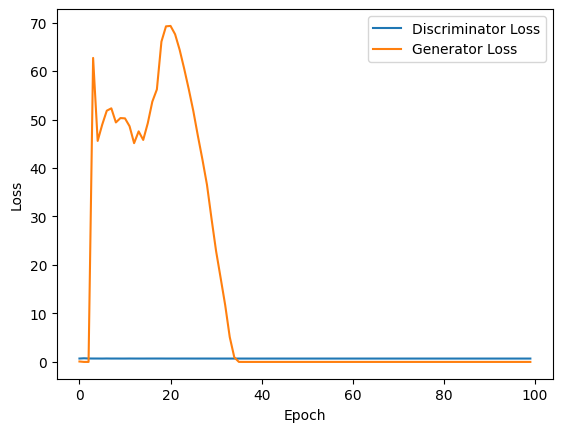

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Reshape
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the synthetic dataset
# Assume df is your DataFrame containing the synthetic data

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=['Product ID', 'Type'])

# Drop UDI, Target, and Failure Type columns
df_encoded = df_encoded.drop(columns=['UDI', 'Target', 'Failure Type'])

# Normalize numerical features
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_encoded)

# Define sequences for LSTM
sequence_length = 10  # Adjust as needed
X = []
y = []
for i in range(len(df_normalized) - sequence_length):
    X.append(df_normalized[i:i + sequence_length])
    y.append(df_normalized[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Split the data into training and evaluation sets (using 10% of the data)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.1, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_eval: {X_eval.shape}")
print(f"Shape of y_eval: {y_eval.shape}")

# Define batch size
batch_size = 10  # Adjust as needed

# Build the Generator model
generator = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, df_normalized.shape[1])),
    BatchNormalization(),
    Dense(df_normalized.shape[1] * sequence_length, activation='sigmoid'),
    Reshape((sequence_length, df_normalized.shape[1]))
])

# Reduce the learning rate
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the generator
generator.compile(loss='binary_crossentropy', optimizer=generator_optimizer)

# Build the Discriminator model
discriminator = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, df_normalized.shape[1])),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the GAN model
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(sequence_length, df_normalized.shape[1]))
x = generator(gan_input)
gan_output = discriminator(x)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Lists to store metrics for plotting
d_losses = []
g_losses = []

# Training the GAN
epochs = 100  # Adjust as needed

for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_seqs = X_train[idx]
    real_labels = np.ones((batch_size, 1))

    gen_seqs = generator.predict(np.random.randn(batch_size, sequence_length, df_normalized.shape[1]))
    gen_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_seqs, real_labels)
    d_loss_fake = discriminator.train_on_batch(gen_seqs, gen_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.randn(batch_size, sequence_length, df_normalized.shape[1])
    valid_labels = np.ones((batch_size, 1))

    g_loss = gan.train_on_batch(noise, valid_labels)
    # Append losses for plotting
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)
    # Reduce the learning rate for the GAN
    gan_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    gan.compile(loss='binary_crossentropy', optimizer=gan_optimizer)
    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

# Generate synthetic sequences for evaluation
num_samples_eval = y_eval.shape[0]  # Use the same number of samples as in the evaluation set
noise_eval = np.random.randn(num_samples_eval, sequence_length, df_normalized.shape[1])
synthetic_sequences = generator.predict(noise_eval)

# Print the shapes for debugging
print(f"Shape of synthetic_sequences: {synthetic_sequences.shape}")

# Inverse transform to obtain the original scale
synthetic_sequences_original_scale = scaler.inverse_transform(synthetic_sequences.reshape(-1, df_normalized.shape[1]))

# Ensure that the number of samples matches the expected number
synthetic_sequences_original_scale = synthetic_sequences_original_scale[:num_samples_eval]

# Print the shapes for debugging
print(f"Shape of synthetic_sequences_original_scale: {synthetic_sequences_original_scale.shape}")

# Evaluate synthetic sequences
mae = mean_absolute_error(y_eval, synthetic_sequences_original_scale)
rmse = np.sqrt(mean_squared_error(y_eval, synthetic_sequences_original_scale))

# Calculate correlation coefficient for each feature
correlations = [pearsonr(y_eval[:, i], synthetic_sequences_original_scale[:, i])[0] for i in range(y_eval.shape[1])]

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Correlation Coefficients: {correlations}")
# Plotting the losses
plt.plot(range(epochs), d_losses, label='Discriminator Loss')
plt.plot(range(epochs), g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from pytorch_fid import fid_score
from scipy.spatial import distance
from sklearn.preprocessing import normalize

# Calculate Jensen-Shannon Divergence
synthetic_dist = normalize(synthetic_sequences_original_scale, axis=0, norm='l1')
real_dist = normalize(y_eval, axis=0, norm='l1')
js_divergence = distance.jensenshannon(synthetic_dist.T, real_dist.T)

print(f"Jensen-Shannon Divergence: {js_divergence}")

Jensen-Shannon Divergence: [0.83160492 0.83160909 0.83164397 0.83162313 0.83160367 0.83164726
 0.83163495 0.83161772 0.83171805 0.83164541 0.83171518 0.83161554
 0.83164606 0.83160392 0.83170249 0.8316546  0.83161813 0.8316322
 0.83160633 0.83166715 0.83158689 0.83164737 0.83160049 0.83164298
 0.8316047  0.83165446 0.8316158  0.83168866 0.83161381 0.83161019
 0.83159205 0.83162596 0.83161515 0.83170896 0.83171539 0.8316553
 0.83164281 0.83159334 0.83159201 0.83159895 0.8316     0.83160755
 0.83165699 0.83167041 0.83155992 0.83168823 0.83160894 0.83159324
 0.83160814 0.83160998 0.8316545  0.83175452 0.831699   0.83160836
 0.83165578 0.83164282 0.83162748 0.83172467 0.83165074 0.83166322
 0.83155312 0.83162378 0.83164701 0.8316345  0.83159813 0.83160468
 0.8317105  0.83162922 0.83166018 0.83160182 0.83161858 0.83165704
 0.8316915  0.83166322 0.83164506 0.8316418  0.83162817 0.83165349
 0.8316353  0.83165592 0.83169007 0.83164293 0.83161074 0.83165134
 0.83156811 0.83161778 0.83157389 0.8

# New Section

In [ ]:
from pytorch_fid import fid_score
from scipy.spatial import distance
from sklearn.preprocessing import normalize

# Calculate Jensen-Shannon Divergence for each feature
js_divergences = []
for i in range(y_eval.shape[1]):
    synthetic_feature_dist = normalize(synthetic_sequences_original_scale[:, i].reshape(1, -1), axis=1, norm='l1')
    real_feature_dist = normalize(y_eval[:, i].reshape(1, -1), axis=1, norm='l1')
    js_divergence_feature = distance.jensenshannon(synthetic_feature_dist.T, real_feature_dist.T)
    js_divergences.append(js_divergence_feature)

# Calculate the average Jensen-Shannon Divergence
average_js_divergence = np.mean(js_divergences)

print(f"Average Jensen-Shannon Divergence: {average_js_divergence}")

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  
[[0.30434783 0.35802469 0.22293364 ... 0.         0.         1.        ]
 [0.31521739 0.37037

1/1 [==============================] - 0s 38ms/step


32/32 [==============================] - 1s 23ms/step
Shape of synthetic_sequences: (999, 10, 10008)
Shape of synthetic_sequences_original_scale: (999, 10008)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Mean Absolute Error: 0.7797056460108764
Root Mean Squared Error: 20.76663558775343
Correlation Coefficients: [-0.00023637765868050675, 0.03479086469618043, -0.030241649146801313, -0.013590010856945871, -0.02018626026989055, -0.027782761402319948, nan, 0.01658047354054481, nan, nan, nan, 0.051985958148767546, nan, nan, nan, nan, -0.0022631602741569443, nan, 0.007318407033473262, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.011718737063671218, nan, nan, nan, nan, nan, nan, 0.026473187829258584, nan, nan, nan, nan, nan, -0.036062638967115486, nan, nan, nan, nan, -0.06417185236899935, nan, -0.041436629281197554, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.022110945083160395, nan, 0.024803522402055085, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.006159933525789947, nan, nan, nan, nan, nan, nan, nan, nan, 0.026824607555774174, nan, nan, nan, nan, nan, nan, na

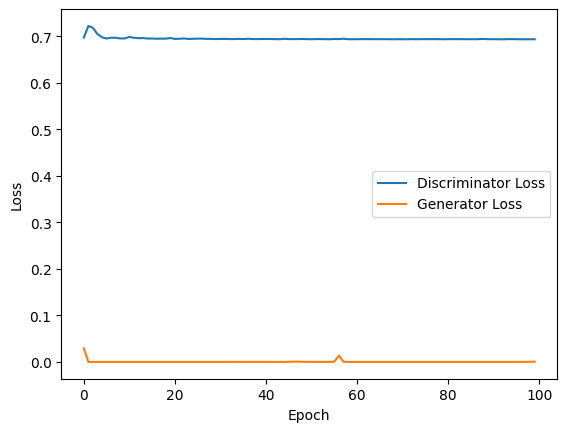

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Reshape
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Load the dataset
file_path ="/content/predictive_maintenance.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset for inspection
print(df.head())

# One-hot encode categorical columns ('Product ID' and 'Type')
df_encoded = pd.get_dummies(df, columns=['Product ID', 'Type'])

# Drop unnecessary columns
df_encoded = df_encoded.drop(columns=['UDI', 'Target', 'Failure Type'])

# Normalize numerical features
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_encoded)

# Display the first few rows of the preprocessed dataset
print(df_normalized[:5])

# Define sequences for LSTM
sequence_length = 10  # Adjust as needed
X = []
y = []
for i in range(len(df_normalized) - sequence_length):
    X.append(df_normalized[i:i + sequence_length])
    y.append(df_normalized[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Print the shape of the sequences
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=['Product ID', 'Type'])

# Drop UDI, Target, and Failure Type columns
df_encoded = df_encoded.drop(columns=['UDI', 'Target', 'Failure Type'])

# Normalize numerical features
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_encoded)

# Define sequences for LSTM
sequence_length = 10  # Adjust as needed
X = []
y = []
for i in range(len(df_normalized) - sequence_length):
    X.append(df_normalized[i:i + sequence_length])
    y.append(df_normalized[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Split the data into training and evaluation sets (using 10% of the data)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.1, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_eval: {X_eval.shape}")
print(f"Shape of y_eval: {y_eval.shape}")

# Define batch size
batch_size = 10  # Adjust as needed

# Build the Generator model
generator = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, df_normalized.shape[1])),
    BatchNormalization(),
    Dense(df_normalized.shape[1] * sequence_length, activation='sigmoid'),
    Reshape((sequence_length, df_normalized.shape[1]))
])

# Reduce the learning rate
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the generator
generator.compile(loss='binary_crossentropy', optimizer=generator_optimizer)

# Build the Discriminator model
discriminator = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, df_normalized.shape[1])),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the GAN model
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(sequence_length, df_normalized.shape[1]))
x = generator(gan_input)
gan_output = discriminator(x)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Lists to store metrics for plotting
d_losses = []
g_losses = []

# Training the GAN
epochs = 100  # Adjust as needed

for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_seqs = X_train[idx]
    real_labels = np.ones((batch_size, 1))

    gen_seqs = generator.predict(np.random.randn(batch_size, sequence_length, df_normalized.shape[1]))
    gen_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_seqs, real_labels)
    d_loss_fake = discriminator.train_on_batch(gen_seqs, gen_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.randn(batch_size, sequence_length, df_normalized.shape[1])
    valid_labels = np.ones((batch_size, 1))

    g_loss = gan.train_on_batch(noise, valid_labels)
    # Append losses for plotting
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)
    # Reduce the learning rate for the GAN
    gan_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    gan.compile(loss='binary_crossentropy', optimizer=gan_optimizer)
    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

# Generate synthetic sequences for evaluation
num_samples_eval = y_eval.shape[0]  # Use the same number of samples as in the evaluation set
noise_eval = np.random.randn(num_samples_eval, sequence_length, df_normalized.shape[1])
synthetic_sequences = generator.predict(noise_eval)

# Print the shapes for debugging
print(f"Shape of synthetic_sequences: {synthetic_sequences.shape}")

# Inverse transform to obtain the original scale
synthetic_sequences_original_scale = scaler.inverse_transform(synthetic_sequences.reshape(-1, df_normalized.shape[1]))

# Ensure that the number of samples matches the expected number
synthetic_sequences_original_scale = synthetic_sequences_original_scale[:num_samples_eval]

# Print the shapes for debugging
print(f"Shape of synthetic_sequences_original_scale: {synthetic_sequences_original_scale.shape}")

# Evaluate synthetic sequences
mae = mean_absolute_error(y_eval, synthetic_sequences_original_scale)
rmse = np.sqrt(mean_squared_error(y_eval, synthetic_sequences_original_scale))

# Calculate correlation coefficient for each feature
correlations = [pearsonr(y_eval[:, i], synthetic_sequences_original_scale[:, i])[0] for i in range(y_eval.shape[1])]

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Correlation Coefficients: {correlations}")
# Plotting the losses
plt.plot(range(epochs), d_losses, label='Discriminator Loss')
plt.plot(range(epochs), g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize correlation coefficients using a heatmap
correlation_matrix = np.corrcoef(y_eval.T, synthetic_sequences_original_scale.T)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.title('Correlation Coefficient Heatmap')
plt.show()

# Plotting the losses
plt.plot(range(epochs), d_losses, label='Discriminator Loss')
plt.plot(range(epochs), g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from pytorch_fid import fid_score
from scipy.spatial import distance
from sklearn.preprocessing import normalize

# Calculate Jensen-Shannon Divergence
synthetic_dist = normalize(synthetic_sequences_original_scale, axis=0, norm='l1')
real_dist = normalize(y_eval, axis=0, norm='l1')
js_divergence = distance.jensenshannon(synthetic_dist.T, real_dist.T)

print(f"Jensen-Shannon Divergence: {js_divergence}")

NameError: ignored